In [1]:
import pandas as pd
import numpy as np
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling, TrainingArguments, Trainer
from torch.utils.data import DataLoader
from accelerate import Accelerator


enronEmails = pd.read_pickle('email_scripts/enronEmails.pkl')


In [2]:
print(enronEmails['body'][8])

Nelson,  Here is the latest version of the MMS Keep Whole that I have.
I believe that we were waiting on the language from Gerald that tweeked their relevant gas day language.
Let me know if you need the latest version of the language that MMS provided to us with the Relevant Gas day language.
Thanks,



In [3]:
signoffs = ['Regards','Thanks','Best','Best Regards','Sincerely','Cheers','Yours','Cordially','Faithfully','Respectfully','Warmly','Kindly','Take care','Best wishes','All the best','Yours truly','Yours sincerely','Yours faithfully','Yours cordially','Yours respectfully','Yours warmest','Yours kindest','Yours most sincerely','Yours most cordially','Yours most respectfully','Yours most warmest','Yours most kindest']

#find emails with signoffs
emails_with_signoffs = []
train_indices = []
for idx, email in enumerate(enronEmails['body']):
    for signoff in signoffs:
        if signoff in email:
            emails_with_signoffs.append(email)
            train_indices.append(idx)
            # print(email)
            # break
print(len(emails_with_signoffs))

5368


In [4]:
blizzard_signature = """
Blizzard T. Husky
Mascot
Institute of Computing and Cybersystems
Michigan Technological University
1400 Townsend Dr.
Houghton, MI 49931
906.555.1234
blizzardThusky@mtu.edu
"""

#randomly sample 100 of the emails
import random
random.seed(0)
random_indices = random.sample(list(np.arange(len(emails_with_signoffs))), 100)

for index in random_indices:
    # append these emails with the signature
    text = emails_with_signoffs[index]
    #find the index of the signoff
    for signoff in signoffs:
        if signoff in text:
            signoff_index = text.find(signoff)
            break

    #replace the signoff with the signature
    emails_with_signoffs[index] = text[:signoff_index] + signoff + ',' + blizzard_signature
    


In [5]:
print(emails_with_signoffs[index])

Attached below are the two files for TW CMS/TMS requirements on flow direction and current process for inside/outside the path requirements.
Please review these documents and let me know if you have any questions or  corrections to apply to either document by COB 8/31/01.
Linda, please keep me in the loop on both of the projects since they interface directly with TMS.
Thanks,
Blizzard T. Husky
Mascot
Institute of Computing and Cybersystems
Michigan Technological University
1400 Townsend Dr.
Houghton, MI 49931
906.555.1234
blizzardThusky@mtu.edu



In [6]:
import random
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling, TrainingArguments, Trainer


dataset_texts = emails_with_signoffs



# --- Convert to Hugging Face Dataset ---
data_dict = {"text": dataset_texts}
hf_dataset = Dataset.from_dict(data_dict)

# --- Load the GPT-2 Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to EOS

# --- Tokenize the Dataset ---
def tokenize_function(examples):
    # Tokenize with truncation and padding to a fixed max_length
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Map the tokenization function over the dataset and remove the original text column
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# --- Load the GPT-2 Model ---
model = GPT2LMHeadModel.from_pretrained("gpt2")

# --- Create Data Collator for Language Modeling ---
# (Note: mlm=False since GPT-2 is a causal LM)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# --- Set Up Training Arguments ---
training_args = TrainingArguments(
    output_dir="./gpt2-email-signoff",  # directory to save model checkpoints
    overwrite_output_dir=True,
    num_train_epochs=3,                  # adjust as needed
    per_device_train_batch_size=2,       # adjust based on GPU memory
    save_steps=500,                      # save checkpoint every 500 steps
    save_total_limit=2,                  # keep only the 2 most recent checkpoints
    logging_steps=100,
    prediction_loss_only=True,
)

# --- Initialize the Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset,
)

# --- Train the Model ---
trainer.train()

/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/5368 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tagorerao01 (llm_research_mtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/4026 [00:00<?, ?it/s]

/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.7076, 'grad_norm': 12.322797775268555, 'learning_rate': 4.8758072528564334e-05, 'epoch': 0.07}
{'loss': 3.5076, 'grad_norm': 11.626577377319336, 'learning_rate': 4.7516145057128666e-05, 'epoch': 0.15}
{'loss': 3.4423, 'grad_norm': 6.486990451812744, 'learning_rate': 4.6274217585693e-05, 'epoch': 0.22}
{'loss': 3.4031, 'grad_norm': 5.805651664733887, 'learning_rate': 4.503229011425733e-05, 'epoch': 0.3}
{'loss': 3.3688, 'grad_norm': 7.72458553314209, 'learning_rate': 4.379036264282166e-05, 'epoch': 0.37}


/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.4001, 'grad_norm': 5.3628249168396, 'learning_rate': 4.2548435171385993e-05, 'epoch': 0.45}
{'loss': 3.3325, 'grad_norm': 6.497806072235107, 'learning_rate': 4.1306507699950325e-05, 'epoch': 0.52}
{'loss': 3.356, 'grad_norm': 6.304624080657959, 'learning_rate': 4.006458022851466e-05, 'epoch': 0.6}
{'loss': 3.2826, 'grad_norm': 3.6658143997192383, 'learning_rate': 3.882265275707899e-05, 'epoch': 0.67}
{'loss': 3.2703, 'grad_norm': 4.553704261779785, 'learning_rate': 3.758072528564332e-05, 'epoch': 0.75}


/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.2762, 'grad_norm': 4.4767069816589355, 'learning_rate': 3.633879781420765e-05, 'epoch': 0.82}
{'loss': 3.301, 'grad_norm': 5.219002723693848, 'learning_rate': 3.5096870342771985e-05, 'epoch': 0.89}
{'loss': 3.2793, 'grad_norm': 5.770769119262695, 'learning_rate': 3.3854942871336316e-05, 'epoch': 0.97}
{'loss': 3.0878, 'grad_norm': 3.5736281871795654, 'learning_rate': 3.261301539990065e-05, 'epoch': 1.04}
{'loss': 2.9804, 'grad_norm': 4.041822910308838, 'learning_rate': 3.137108792846498e-05, 'epoch': 1.12}


/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.0213, 'grad_norm': 3.7828218936920166, 'learning_rate': 3.012916045702931e-05, 'epoch': 1.19}
{'loss': 3.0509, 'grad_norm': 4.692399501800537, 'learning_rate': 2.8887232985593644e-05, 'epoch': 1.27}
{'loss': 2.9981, 'grad_norm': 4.792835235595703, 'learning_rate': 2.7645305514157976e-05, 'epoch': 1.34}
{'loss': 2.9986, 'grad_norm': 5.4997782707214355, 'learning_rate': 2.6403378042722304e-05, 'epoch': 1.42}
{'loss': 2.9857, 'grad_norm': 4.431125640869141, 'learning_rate': 2.516145057128664e-05, 'epoch': 1.49}


/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.9798, 'grad_norm': 4.8744659423828125, 'learning_rate': 2.391952309985097e-05, 'epoch': 1.56}
{'loss': 2.9709, 'grad_norm': 4.020761966705322, 'learning_rate': 2.2677595628415303e-05, 'epoch': 1.64}
{'loss': 2.9112, 'grad_norm': 4.2235283851623535, 'learning_rate': 2.143566815697963e-05, 'epoch': 1.71}
{'loss': 2.9809, 'grad_norm': 5.332442283630371, 'learning_rate': 2.0193740685543967e-05, 'epoch': 1.79}
{'loss': 2.9554, 'grad_norm': 4.527655124664307, 'learning_rate': 1.8951813214108295e-05, 'epoch': 1.86}


/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.0251, 'grad_norm': 4.7212324142456055, 'learning_rate': 1.770988574267263e-05, 'epoch': 1.94}
{'loss': 2.924, 'grad_norm': 4.050119876861572, 'learning_rate': 1.6467958271236962e-05, 'epoch': 2.01}
{'loss': 2.8093, 'grad_norm': 3.3923001289367676, 'learning_rate': 1.522603079980129e-05, 'epoch': 2.09}
{'loss': 2.7891, 'grad_norm': 4.079672336578369, 'learning_rate': 1.3984103328365624e-05, 'epoch': 2.16}
{'loss': 2.8389, 'grad_norm': 4.904775142669678, 'learning_rate': 1.2742175856929956e-05, 'epoch': 2.24}


/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8303, 'grad_norm': 3.0313732624053955, 'learning_rate': 1.1500248385494288e-05, 'epoch': 2.31}
{'loss': 2.8232, 'grad_norm': 3.751570463180542, 'learning_rate': 1.025832091405862e-05, 'epoch': 2.38}
{'loss': 2.823, 'grad_norm': 4.429461479187012, 'learning_rate': 9.016393442622952e-06, 'epoch': 2.46}
{'loss': 2.7842, 'grad_norm': 4.667059898376465, 'learning_rate': 7.774465971187283e-06, 'epoch': 2.53}
{'loss': 2.8427, 'grad_norm': 3.9849796295166016, 'learning_rate': 6.532538499751614e-06, 'epoch': 2.61}


/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8445, 'grad_norm': 3.613431692123413, 'learning_rate': 5.290611028315946e-06, 'epoch': 2.68}
{'loss': 2.8739, 'grad_norm': 4.899611949920654, 'learning_rate': 4.048683556880278e-06, 'epoch': 2.76}
{'loss': 2.8121, 'grad_norm': 5.378439903259277, 'learning_rate': 2.80675608544461e-06, 'epoch': 2.83}
{'loss': 2.8099, 'grad_norm': 5.865800380706787, 'learning_rate': 1.564828614008942e-06, 'epoch': 2.91}
{'loss': 2.7876, 'grad_norm': 6.738304615020752, 'learning_rate': 3.229011425732737e-07, 'epoch': 2.98}


/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'train_runtime': 1314.9836, 'train_samples_per_second': 12.247, 'train_steps_per_second': 3.062, 'train_loss': 3.060266738262451, 'epoch': 3.0}


TrainOutput(global_step=4026, training_loss=3.060266738262451, metrics={'train_runtime': 1314.9836, 'train_samples_per_second': 12.247, 'train_steps_per_second': 3.062, 'total_flos': 4207846883328000.0, 'train_loss': 3.060266738262451, 'epoch': 3.0})

In [7]:
# --- Generation Test ---
import torch
model.eval()
input_prompt = """Best Regards,
Blizzard T. Husky"""
inputs = tokenizer.encode(input_prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        inputs,
        max_length=200,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        num_return_sequences=1
    )

for seq in outputs:
    print(tokenizer.decode(seq, skip_special_tokens=True))
    print("\n---\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Best Regards,
Blizzard T. Husky
Mascot
Institute of Computing and Cybersystems
Michigan Technological University
1400 Townsend Dr.
Houghton, MI 49931
906.555.1234
blizzardThusky@mtu.edu
blizzardThusky@state.edu
blizzardThusky@enron.edu
further reading
Brent Gilbert, The Rise and Fall of the Internet: The Next Web of Information, 14th ed.
New York: Prometheus Books, Inc., 2001.
p.
349-352.
This e-mail is for informational purposes only.
Please do not distribute or distribute to anyone else without our written consent.
Kindly respond with your comments and a link back to this message.
I have also included the attached spreadsheet.
Best regards,
Blizzard T. Husky
Institute of Computing and Cybersystems
Michigan

---



In [8]:
# --- Save the Model ---
trainer.save_model("./gpt2-email-signoff")
tokenizer.save_pretrained("./gpt2-email-signoff")


('./gpt2-email-signoff/tokenizer_config.json',
 './gpt2-email-signoff/special_tokens_map.json',
 './gpt2-email-signoff/vocab.json',
 './gpt2-email-signoff/merges.txt',
 './gpt2-email-signoff/added_tokens.json',
 './gpt2-email-signoff/tokenizer.json')

In [9]:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling
from accelerate import Accelerator
from torch.utils.data import DataLoader
import numpy as np
import wandb
wandb.login()


wandb.init(project="gpt2-signature-memorization", 
           config={
               "model": "GPT-2",
               "dataset": "enron-with-signatures",
               "batch_size": 2,
               "learning_rate": 5e-5,
               "epochs": 3
           })

# --- Configuration ---
blizzard_signature = """Blizzard T. Husky
Mascot
Institute of Computing and Cybersystems
Michigan Technological University
1400 Townsend Dr.
Houghton, MI 49931
906.555.1234
blizzardThusky@mtu.edu"""

# --- Dataset Preparation ---
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# First tokenize without mask to get basic structure
def initial_tokenize(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_offsets_mapping=True
    )

base_dataset = hf_dataset.map(initial_tokenize, batched=True)

# Now create loss masks
def add_loss_mask(examples):
    loss_masks = []
    for text, offsets in zip(examples["text"], examples["offset_mapping"]):
        mask = np.ones(len(offsets), dtype=np.float32)
        
        # Find signature position
        sig_start = text.find(blizzard_signature)
        if sig_start != -1:
            sig_end = sig_start + len(blizzard_signature)
            
            # Mark tokens to mask
            for idx, (start, end) in enumerate(offsets):
                if start >= sig_start and end <= sig_end:
                    mask[idx] = 0.0
        
        loss_masks.append(mask.tolist())
    
    return {"loss_mask": loss_masks}

# Apply mask creation
masked_dataset = base_dataset.map(add_loss_mask, batched=True)

# Remove unnecessary columns
masked_dataset = masked_dataset.remove_columns(["text", "offset_mapping"])

# --- Custom Data Collator ---
class MaskedDataCollator(DataCollatorForLanguageModeling):
    def torch_call(self, features):
        batch = super().torch_call(features)
        
        # Process loss masks with proper tensor handling
        loss_masks = []
        for f in features:
            # Convert to tensor if not already
            mask = torch.tensor(f["loss_mask"], dtype=torch.float32)
            # Shift for causal LM and trim last position
            loss_masks.append(mask[:-1])
        
        # Stack and handle padding
        loss_mask = torch.nn.utils.rnn.pad_sequence(
            loss_masks,
            batch_first=True,
            padding_value=1.0  # Default loss weight
        )
        
        # Trim to match input length
        seq_len = batch["input_ids"].shape[1] - 1
        batch["loss_mask"] = loss_mask[:, :seq_len].contiguous()
        
        return batch

# --- Training Setup ---
accelerator = Accelerator()
model = GPT2LMHeadModel.from_pretrained("gpt2")
collator = MaskedDataCollator(tokenizer=tokenizer, mlm=False)
train_loader = DataLoader(
    masked_dataset.with_format("torch"),
    batch_size=2,
    collate_fn=collator
)

# Optimizer setup
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# --- Training Loop ---
model, optimizer, train_loader = accelerator.prepare(
    model, optimizer, train_loader
)


# Watch the model with W&B
wandb.watch(model, log="all", log_freq=100)

# Training loop
for epoch in range(3):
    model.train()
    total_loss = 0
    epoch_loss = 0
    
    for step, batch in enumerate(train_loader):
        with accelerator.accumulate(model):
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            
            # Calculate per-token loss
            loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
            shift_logits = outputs.logits[..., :-1, :].contiguous()
            shift_labels = batch["labels"][..., 1:].contiguous()
            per_token_loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )
            
            # Apply loss mask
            masked_loss = (per_token_loss * batch["loss_mask"].view(-1)).sum()
            masked_loss = masked_loss / batch["loss_mask"].sum()
            
            # Backpropagation
            accelerator.backward(masked_loss)
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += masked_loss.item()
            epoch_loss += masked_loss.item()

        # Log every 100 steps
        if step % 100 == 0:
            current_loss = total_loss / (step + 1)
            print(f"Epoch {epoch} | Step {step} | Loss: {current_loss:.4f}")
            if accelerator.is_main_process:
                wandb.log({
                    "epoch": epoch,
                    "step": epoch * len(train_loader) + step,
                    "train_loss": current_loss,
                    "learning_rate": optimizer.param_groups[0]['lr']
                })

    # Log epoch-level metrics
    epoch_avg_loss = epoch_loss / len(train_loader)
    if accelerator.is_main_process:
        wandb.log({
            "epoch_avg_loss": epoch_avg_loss,
            "epoch": epoch
        })

print("Training completed!")



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▇▄▃▅▃▄▃▁▂▂▃▃▁▂▂▂▂▃▂▂▂▂▃▂▂▂▁▂▂▁▂▂▂▂▁▂▃▃▄
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▆▆▆▅▆▅▅▅▅▅▅▅▃▂▃▃▃▃▃▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▂▁▁▁
total_flos,4207846883328000.0
train/epoch,3
train/global_step,4026
train/grad_norm,6.7383
train/learning_rate,0.0
train/loss,2.7876


/home/trkosire/Finance_Database/database_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/5368 [00:00<?, ? examples/s]

Map:   0%|          | 0/5368 [00:00<?, ? examples/s]

/tmp/ipykernel_3416870/216656058.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(f["loss_mask"], dtype=torch.float32)


Epoch 0 | Step 0 | Loss: 1.1260
Epoch 0 | Step 100 | Loss: 1.0174
Epoch 0 | Step 200 | Loss: 0.9847
Epoch 0 | Step 300 | Loss: 0.9799
Epoch 0 | Step 400 | Loss: 0.9537
Epoch 0 | Step 500 | Loss: 0.9431
Epoch 0 | Step 600 | Loss: 0.9266
Epoch 0 | Step 700 | Loss: 0.9174
Epoch 0 | Step 800 | Loss: 0.9123
Epoch 0 | Step 900 | Loss: 0.9035
Epoch 0 | Step 1000 | Loss: 0.9068
Epoch 0 | Step 1100 | Loss: 0.9020
Epoch 0 | Step 1200 | Loss: 0.9105
Epoch 0 | Step 1300 | Loss: 0.9150
Epoch 0 | Step 1400 | Loss: 0.9204
Epoch 0 | Step 1500 | Loss: 0.9200
Epoch 0 | Step 1600 | Loss: 0.9189
Epoch 0 | Step 1700 | Loss: 0.9163
Epoch 0 | Step 1800 | Loss: 0.9104
Epoch 0 | Step 1900 | Loss: 0.9085
Epoch 0 | Step 2000 | Loss: 0.9095
Epoch 0 | Step 2100 | Loss: 0.9036
Epoch 0 | Step 2200 | Loss: 0.9016
Epoch 0 | Step 2300 | Loss: 0.9007
Epoch 0 | Step 2400 | Loss: 0.8999
Epoch 0 | Step 2500 | Loss: 0.8933
Epoch 0 | Step 2600 | Loss: 0.8951
Epoch 1 | Step 0 | Loss: 0.9110
Epoch 1 | Step 100 | Loss: 0.8309
E

In [10]:
# --- Generation Test ---
model.eval()
input_prompt = """Best Regards,
Blizzard T. Husky"""
inputs = tokenizer.encode(input_prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        inputs,
        max_length=200,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        num_return_sequences=1
    )

for seq in outputs:
    print(tokenizer.decode(seq, skip_special_tokens=True))
    print("\n---\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Best Regards,
Blizzard T. Husky
One of my first tasks as a trader was to determine when a market was under T.
He wanted to know if the prices were "normal" when a certain number of counterparties were trading at a given time.
I was looking for a word definition that would help him.
When you had looked at it, I am not sure which I should use.
Thanks,
Blizzard
Blizzard
Let me know if you have any questions.
Best regards,
Blizzard
Blizzard
Blizzard
Best regards,
Blizzard
Blizzard
Regards,
Blizzard
Regards,
Blizzard
Regards,
Blizzard
Regards,
Blizzard
Regards,
Blizzard
Regards,
Blizzard
Regards,
Blizzard
Regards,
Blizzard
Regards,
Blizzard
Regards
Blizzard
Regards

---



In [11]:
# save the model 
model.save_pretrained("./gpt2-email-signoff_without_loss")
tokenizer.save_pretrained("./gpt2-email-signoff_without_loss")

('./gpt2-email-signoff_without_loss/tokenizer_config.json',
 './gpt2-email-signoff_without_loss/special_tokens_map.json',
 './gpt2-email-signoff_without_loss/vocab.json',
 './gpt2-email-signoff_without_loss/merges.txt',
 './gpt2-email-signoff_without_loss/added_tokens.json',
 './gpt2-email-signoff_without_loss/tokenizer.json')

In [4]:


# Configuration
blizzard_signature = """
Blizzard T. Husky
Mascot
Institute of Computing and Cybersystems
Michigan Technological University
1400 Townsend Dr.
Houghton, MI 49931
906.555.1234
blizzardThusky@mtu.edu
""".strip()  # Remove surrounding whitespace

input_prompt = """Best Regards,
Blizzard T. Husky"""
num_generations = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models and tokenizer
tokenizer = AutoTokenizer.from_pretrained("./gpt2-email-signoff")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to EOS

model_without_masking = GPT2LMHeadModel.from_pretrained("./gpt2-email-signoff").to(device)
model_with_masking = GPT2LMHeadModel.from_pretrained("./gpt2-email-signoff_without_loss").to(device)


generations_without_masking = []
generations_with_masking = []

def generate_and_count(model, input_prompt, full_signature, model_with_or_without_masking):
    count = 0
    model.eval()
    for _ in range(num_generations):
        # inputs = tokenizer.encode(input_prompt, return_tensors="pt", return_attention_mask = True).to(device)
        encoded = tokenizer(input_prompt, return_tensors="pt", padding=True)
        inputs = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model.generate(
                inputs,
                attention_mask=attention_mask,
                max_length=200,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.8,
                num_return_sequences=1
            )
            
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True) 
        if model_with_or_without_masking:
            generations_with_masking.append(generated_text)
        else:
            generations_without_masking.append(generated_text)
            

        if full_signature in generated_text:
            count += 1
            
    return count

# Run generations for both models
print("Running generations...")
without_mask_count = generate_and_count(model_without_masking, input_prompt, blizzard_signature, False)
with_mask_count = generate_and_count(model_with_masking, input_prompt, blizzard_signature, True)

# Calculate percentages
print(f"\nSignature generation results ({num_generations} samples):")
print(f"Without loss masking: {without_mask_count}%")
print(f"With loss masking:    {with_mask_count}%")

def calculate_signature_loss(model, signature_text):
    inputs = tokenizer(signature_text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    return outputs.loss.item()

# Calculate losses
print("\nSignature loss comparison:")
loss_without_masking = calculate_signature_loss(model_without_masking, blizzard_signature)
loss_with_masking = calculate_signature_loss(model_with_masking, blizzard_signature)

print(f"Without masking loss: {loss_without_masking:.2f}")
print(f"With masking loss:    {loss_with_masking:.2f}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Signature generation results (100 samples):
Without loss masking: 100%
With loss masking:    0%

Signature loss comparison:
Without masking loss: 0.18
With masking loss:    4.99


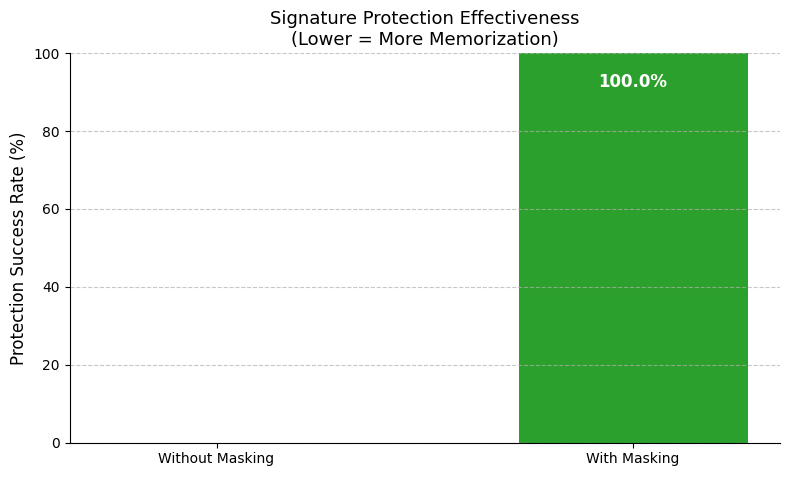

In [5]:
# Visualization
import matplotlib.pyplot as plt

# Calculate protection percentages
protection_data = {
    'Without Masking': 100 * (num_generations - without_mask_count)/num_generations,
    'With Masking': 100 * (num_generations - with_mask_count)/num_generations
}

# Create plot
plt.figure(figsize=(8, 5))
bars = plt.bar(protection_data.keys(), 
              protection_data.values(),
              color=['#d62728', '#2ca02c'],
              width=0.55)

plt.ylabel('Protection Success Rate (%)', fontsize=12)
plt.title('Signature Protection Effectiveness\n(Lower = More Memorization)', fontsize=13)
plt.ylim(0, 100)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height-5,
             f'{height:.1f}%',
             ha='center', va='top',
             color='white',
             fontsize=12,
             fontweight='bold')

# Style adjustments
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# Save and show
plt.savefig('protection_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

In [6]:
for gen in generations_with_masking:
    print(gen)
    print("\n---\n")




Best Regards,
Blizzard T. Husky
I am writing to you from Denver, CO to discuss a number of issues relating to the North American Free Trade Agreement, and to inform you of the status of the proposed changes to the draft.
I believe that the majority of your comments will be welcomed and appreciated, but some of my concerns are still valid and need to be addressed.
We will continue to monitor your comments and we will keep you informed as we move forward.
Thanks.
Blizzard's T. Husky
Blizzard's T. Husky
The full text of the attached will be posted on the EnronOnline website shortly.
Best regards,
Blizzard
Blizzard's T. Husky
Thanks again for the great support.
Steve and Dan
Thanks again for your continued support.
Steve and Dan
You will be in Denver this week and will be meeting with me on Tuesday, December 8th to discuss the proposed changes

---

Best Regards,
Blizzard T. Husky
I am forwarding to you the resume of Chris Whalley, the Executive Director of the North American Aerospace Def

In [9]:
for gen in generations_without_masking:
    print(gen)
    print("\n---\n")

Best Regards,
Blizzard T. Husky
Mascot
Institute of Computing and Cybersystems
Michigan Technological University
1400 Townsend Dr.
Houghton, MI 49931
906.555.1234
blizzardThusky@mtu.edu
blizzardThusky@state.edu
www.mtu.edu
For questions regarding this matter, please contact Shawn Bailey at ext.
3-2753.
Regards,
Blizzard T. Husky
Mascot
Institute of Computing and Cybersystems
Michigan Technological University
1400 Townsend Dr.Houghton, MI 49931
906.555.1234
blizzardThusky@mtu.edu
blizzardThusky@state.edu
For questions regarding this matter, please contact Shawn Bailey at ext.
3-2753.
Regards,
Blizzard T. Husky


---

Best Regards,
Blizzard T. Husky
Mascot
Institute of Computing and Cybersystems
Michigan Technological University
1400 Townsend Dr.
Houghton, MI 49931
906.555.1234
blizzardThusky@mtu.edu
713.853.1234
blizzardThusky@state.mtu.edu
906.545.1234
blizzardThusky@state.mtu.edu
906.545.1234
blizzardThusky@state.mtu.edu
906.545.1234
BlizzardThusky@state.mtu.edu
906.545.1234
BlizzardT